## Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import requests

#### Importing archive File

In [2]:
dogs_df = pd.read_csv('twitter-archive-enhanced.csv')
dogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
dogs_df.tweet_id.nunique()

2356

#### Wrangling tweet image prediction image_predictions.tsv file from Udacity URL

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(r.content)

In [6]:
predict_df = pd.read_csv('image_predictions.tsv', sep='\t')
predict_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Wrangling twitter retweets and likes using twiter API

In [7]:
consumer_key = '*************************'
consumer_secret = '**************************************************'

access_token = '**************************************************'
access_secret = '*********************************************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify  = True)

In [8]:
from pprint import pprint
import json
import os
import time

def dump_tweet_json(tweet_id, file):
    """
    query the tweet json file specified by twitter id 'tweet_id'
    using twitter API tweepy, parse the json object and write it to the
    file 'file'
    
    Warning! file is assumed open in writing mode
    """
    tweet_status = api.get_status(tweet_id, tweet_mode='extended')
    json.dump(tweet_status._json, file)
    

In [9]:
deleted_tweets_ids = []
rate_limit_exceeded_tweets  = []

with open('tweet_json.txt', 'w') as file:
    
    ## First Path of Querying tweets
    ## collecting deleted tweets ids and rate_limit_exceeded_tweets
    file.write('[\n')
    for tweet_id in dogs_df.tweet_id:
        try:
            
            dump_tweet_json(tweet_id, file)
            file.write(',\n')
        
        except tweepy.error.RateLimitError:
            rate_limit_exceeded_tweets.append(tweet_id)
        
        except Exception as e:
            deleted_tweets_ids.append(tweet_id)
            print(e,' ', tweet_id)
    
    ## Second Path of Querying tweets
    ## Making sure to collect rate_limit_exceeded_tweets if any 
    
    while rate_limit_exceeded_tweets:
        try:
            tweet_id = rate_limit_exceeded_tweets[0]
            dump_tweet_json(tweet_id, file)
            file.write(',\n')
            rate_limit_exceeded_tweets.pop(0)
            
        except tweepy.error.RateLimitError:
            time.sleep(60)
            
        except tweepy.error.TweepError as tr:
            if tr.message[0]['code'] == 144:
                rate_limit_exceeded_tweets.pop(0)
            else:
                print('Twitter Error: ', twitter_err)
        
        except Exception as e:
            print(e)
            
    file.seek(file.tell() - 3, os.SEEK_SET)
    file.write('\n]')

[{'code': 144, 'message': 'No status found with that ID.'}]   888202515573088257
[{'code': 144, 'message': 'No status found with that ID.'}]   873697596434513921
[{'code': 144, 'message': 'No status found with that ID.'}]   872668790621863937
[{'code': 144, 'message': 'No status found with that ID.'}]   872261713294495745
[{'code': 144, 'message': 'No status found with that ID.'}]   869988702071779329
[{'code': 144, 'message': 'No status found with that ID.'}]   866816280283807744
[{'code': 144, 'message': 'No status found with that ID.'}]   861769973181624320
[{'code': 144, 'message': 'No status found with that ID.'}]   856602993587888130
[{'code': 144, 'message': 'No status found with that ID.'}]   845459076796616705
[{'code': 144, 'message': 'No status found with that ID.'}]   844704788403113984
[{'code': 144, 'message': 'No status found with that ID.'}]   842892208864923648
[{'code': 144, 'message': 'No status found with that ID.'}]   837012587749474308
[{'code': 144, 'message': 'N

Rate limit reached. Sleeping for: 309


[{'code': 144, 'message': 'No status found with that ID.'}]   754011816964026368
[{'code': 144, 'message': 'No status found with that ID.'}]   680055455951884288


Rate limit reached. Sleeping for: 320


In [7]:
deleted_tweets_ids = [888202515573088257, 873697596434513921,   872668790621863937,   872261713294495745,   869988702071779329,  
     866816280283807744,   861769973181624320,  856602993587888130,   845459076796616705,  844704788403113984,
     842892208864923648, 837012587749474308, 827228250799742977, 812747805718642688, 802247111496568832, 775096608509886464, 
     770743923962707968, 754011816964026368, 680055455951884288]

In [8]:
len_del = len(str(deleted_tweets_ids[5]))
for del_tweet in deleted_tweets_ids:
    assert len(str(del_tweet)) == len_del

In [9]:
## Reading needed information from tweet_json to a dataframe
## needed info.: retweet_count, favorite_count
## in_reply_to_status_id, in_reply_to_user_id

df = pd.read_json('tweet_json.txt')
df.head(3)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",37554,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,8193,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",32278,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,6060,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",24320,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,4008,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [10]:
df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

In [11]:
## Checking completeness of wrangled parsed data and given data 
## After parsing the dataframe obs should be smaller than the given original data obs
## by just the deleted tweets

assert dogs_df.shape[0] == len(deleted_tweets_ids) + df.shape[0]

In [12]:
## Interested tweets info 

tweets_add_df = df[['retweet_count' , 'favorite_count', 'in_reply_to_status_id', 
                    'in_reply_to_user_id', 'is_quote_status', 'quoted_status_id', 'retweeted_status']]

tweets_add_df.head(3)

,retweet_count,favorite_count,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,quoted_status_id,retweeted_status
0,8193,37554,NaN,NaN,False,NaN,NaN
1,6060,32278,NaN,NaN,False,NaN,NaN
2,4008,24320,NaN,NaN,False,NaN,NaN


In [13]:
list(df['user'].apply(pd.Series))

['id',
 'id_str',
 'name',
 'screen_name',
 'location',
 'description',
 'url',
 'entities',
 'protected',
 'followers_count',
 'friends_count',
 'listed_count',
 'created_at',
 'favourites_count',
 'utc_offset',
 'time_zone',
 'geo_enabled',
 'verified',
 'statuses_count',
 'lang',
 'contributors_enabled',
 'is_translator',
 'is_translation_enabled',
 'profile_background_color',
 'profile_background_image_url',
 'profile_background_image_url_https',
 'profile_background_tile',
 'profile_image_url',
 'profile_image_url_https',
 'profile_banner_url',
 'profile_link_color',
 'profile_sidebar_border_color',
 'profile_sidebar_fill_color',
 'profile_text_color',
 'profile_use_background_image',
 'has_extended_profile',
 'default_profile',
 'default_profile_image',
 'following',
 'follow_request_sent',
 'notifications',
 'translator_type']

In [14]:
## Collecting info about users posting the tweets, most of them expected to be WeRateDogs page
## but if the tweet is a retweet, Different users shall be expected 

users_info = df['user'].apply(pd.Series)[['id', 'name', 'created_at', 'friends_count', 'followers_count', 'favourites_count', 'listed_count', 'statuses_count']]
users_info.head()

,id,name,created_at,friends_count,followers_count,favourites_count,listed_count,statuses_count
0,4196983835,WeRateDogs™,Sun Nov 15 21:41:29 +0000 2015,12,8026597,141917,6187,10170
1,4196983835,WeRateDogs™,Sun Nov 15 21:41:29 +0000 2015,12,8026597,141917,6187,10170
2,4196983835,WeRateDogs™,Sun Nov 15 21:41:29 +0000 2015,12,8026597,141917,6187,10170
3,4196983835,WeRateDogs™,Sun Nov 15 21:41:29 +0000 2015,12,8026597,141917,6187,10170
4,4196983835,WeRateDogs™,Sun Nov 15 21:41:29 +0000 2015,12,8026597,141917,6187,10170


<hr>

## Assessing and Defining Issues in the Data

In [15]:
dogs_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [16]:
tweets_add_df.head()

,retweet_count,favorite_count,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,quoted_status_id,retweeted_status
0,8193,37554,NaN,NaN,False,NaN,NaN
1,6060,32278,NaN,NaN,False,NaN,NaN
2,4008,24320,NaN,NaN,False,NaN,NaN
3,8347,40905,NaN,NaN,False,NaN,NaN
4,9040,39097,NaN,NaN,False,NaN,NaN


In [17]:
predict_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Assessing dogs_df

> In this section, I will assess the data. In every step, I may find an issue and will document it in markdown cells, 
at the end of the section, all issues will be summarized and classified.

In [18]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [19]:
dogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [20]:
dogs_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [21]:
dogs_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1173,720340705894408192,NaN,NaN,2016-04-13 19:59:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Derek. He just got balled on. Can't even get up. Poor thing. 10/10 hang in there pupper https://t.co/BIRRF3bcWH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720340705894408192/photo/1,10,10,Derek,None,None,pupper,None
1776,677961670166224897,NaN,NaN,2015-12-18 21:20:32 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Izzy. She's showing off the dance moves she's been working on. 11/10 I guess hard work pays off https://t.co/4JS92YAxTi,NaN,NaN,NaN,https://vine.co/v/iKuMDuYV0aZ,11,10,Izzy,None,None,None,None
1363,702932127499816960,NaN,NaN,2016-02-25 19:04:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chip. He's an Upper West Nile Pantaloon. Extremely deadly. Will rip your throat out. 6/10 might still pet https://t.co/LUFnwzznaV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702932127499816960/photo/1,6,10,Chip,None,None,None,None
918,756651752796094464,NaN,NaN,2016-07-23 00:46:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gert. He just wants you to be happy. 11/10 would pat on the head so damn well https://t.co/l0Iwj6rLFW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756651752796094464/photo/1,11,10,Gert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None


In [22]:
dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

From visual assessment and info() function:
* the source column contains an html link tag that contians three types of information in one column, the source of the tweet, link of the source, 'rel' attribute.
* The doggo, pupper and puppo are all possible dog stage, so it's better  of to represent them by one column e.g dog_stage column and the stage_column should be categorized.
* Column doggo, pupper, and puppo sometimes are all Nones while a dog should be really in one of the three stages or sometimes big doggo is considered woofer, but here in the system, it seems dogs are categorized between only pupper, doggo and puppo and from further investigation visual assessment, it seems that the category of the dog is extracted from the text, so when the tweet text doesn't contain any of these words or use different abbreviations like 'pup', the values are none.
* Not all ratings numerators are higher than 10, some ratings actually below 10, from visual assessment, and seeing the dates, it seems all in this small sample posted in 2015, more programmatic assessment needed here.
* The (in_reply_to_status_id, in_reply_to_user_id), (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)	seems to contain many Nones, as we see from the info function, just 78 non-nulls for in_reply and 181 for retweets and that might not come as a surprise since most tweets are originally posted by the page, and such official rating pages may not retweet often, rather a personal twitter may contain many retweets.
* The doggo, floofer, pupper, puppo doesn't contain any null entries from the info() function although we seem many Nones from the visual assessment and could be that string 'None' is inserted in them not object None.
* expanded_urls contains 59 null objects that means there are 59 tweets with no urls of photos or any url included in the text, this data could be gathered from the json file, if exists.
* There is a 'None' names in the tail and 'a' names, too. Checking the text, it seems names are extracted from statements in the form 'This is name', 'Here is name', if anything came in place of name, it's would be the name, and if the pattern doesn' exist, it will be None. A better text pattern may be used, but from this sample head, tail, sample, Sometimes names aren't really stated, somtimes breed, type or origin is stated, so we should furhter investigate name column.
* 'tweet_id' is integer, 'in_reply_to_status_id', 'retweeted_status_user_id', 'retweeted_status_id', 'retweeted_status_user_id' are floats. Finally, timestamp columns are string objects not datetime.
* Finally, the 'text' columns contains two pieces of information both the text and the t.co url link wrappers. So this is a tidyness issue. Moreover, from visual assessment and checking url, t.co links usually refer to the same page as the expaned_url, but this I will check later

Next I will check for values of every interesting column to make sure case of 'None' strings doesn't happen to other columns

In [23]:
def value_counts_per_column(df, columns):
    """
    Takes a dataframe and a set of columns in the dataframe 
    and prints out the value_counts of each column
    """
    for column in columns:
        print(df[column].value_counts())
        print('\n\n', '==' * 20, '\n\n')
        

In [24]:
list(dogs_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [25]:
value_counts_per_column(dogs_df, ['name', 'doggo', 'floofer', 'pupper', 'puppo', 'source'])

None         745
a            55 
Charlie      12 
Lucy         11 
Cooper       11 
Oliver       11 
Penny        10 
Tucker       10 
Lola         10 
Winston      9  
Bo           9  
Sadie        8  
the          8  
Toby         7  
an           7  
Buddy        7  
Bailey       7  
Daisy        7  
Jack         6  
Bella        6  
Rusty        6  
Scout        6  
Leo          6  
Oscar        6  
Dave         6  
Stanley      6  
Koda         6  
Milo         6  
Jax          6  
very         5  
            ..  
Grizzie      1  
Noah         1  
Petrick      1  
Iggy         1  
Geno         1  
Zuzu         1  
Simba        1  
Goose        1  
Mac          1  
Jim          1  
Cilantro     1  
Tess         1  
Willem       1  
Major        1  
Ambrose      1  
Pip          1  
Mo           1  
Edgar        1  
Pinot        1  
Tilly        1  
Alexander    1  
Brudge       1  
Crimson      1  
Milky        1  
Damon        1  
Brian        1  
Emanuel      1  
Dug          1

**Observations per column(s):**
* 'name': There are many Nones and other unreasonable names like 'a', 'an', 'old', 'the'
* 'doggo', 'floofer', 'pupper', 'puppo': Values are either None or their column name, 'None' are dominant in those columns. 
* 'source': is either from Twitter for iPhone app, Vine, the Web or TweetDeck, we can see that the rel attribute takes always 'nofollow' value, so actually its existence when tidying up the column may be irrelevant, more space for no benefit, we make make a note that all links are 'nofollow' for browsers. Hence, I may argue that the html attr 'rel' is not important in our investigation or representation of the data-set.

In [26]:
## Further investigating name column

pd.set_option('display.max_rows', 500)

dogs_df['name'].value_counts()[dogs_df['name'].value_counts() > 3]

None        745
a           55 
Charlie     12 
Lucy        11 
Cooper      11 
Oliver      11 
Penny       10 
Tucker      10 
Lola        10 
Winston     9  
Bo          9  
Sadie       8  
the         8  
Toby        7  
an          7  
Buddy       7  
Bailey      7  
Daisy       7  
Jack        6  
Bella       6  
Rusty       6  
Scout       6  
Leo         6  
Oscar       6  
Dave        6  
Stanley     6  
Koda        6  
Milo        6  
Jax         6  
very        5  
Chester     5  
Larry       5  
Louis       5  
Sunny       5  
Bentley     5  
Phil        5  
Gus         5  
George      5  
Sammy       5  
Oakley      5  
Alfie       5  
Finn        5  
Loki        4  
Bruce       4  
Brody       4  
Cassie      4  
Ruby        4  
Clarence    4  
Jerry       4  
Sophie      4  
Moose       4  
Bear        4  
just        4  
Dexter      4  
Reginald    4  
quite       4  
Chip        4  
Duke        4  
Derek       4  
Maddie      4  
Winnie      4  
Sampson     4  
Beau    

<hr>

**Investigating name column furhter we notice those issues:**
1. very high count of None (745)
2. Articles like 'a', 'an', 'the' adverbs like 'just', 'very', 'quite', adj like 'old' and others like  'one'.
3. Some Strange names like Chip Scooter Moose Bentley Shadow, but names by nature aren't justified, so I will dig further to those specific names, but most likely they won't considered quality issues.

The articles, adverbs and others like 'one' are all begin with lower case letters, that might help cleaning those data instead of getting list of all possible articles, adverbs and pronouns to check their existence in the names column

<hr>

In [27]:
def any_None_empty_object(df):
    """
    checks there is any 'None' or empty '' string objects values in string 
    columns and prints out the column name if any
    """
    for column in list(df):
        if df[column].dtype == np.object:
            if any(df[column].str.lower() == 'none'):
                print(column, "'none' strings exists")
            elif any(df[column].str.strip() == ''):
                print(column, 'Empty strings exist')

In [28]:
any_None_empty_object(dogs_df)

name 'none' strings exists
doggo 'none' strings exists
floofer 'none' strings exists
pupper 'none' strings exists
puppo 'none' strings exists


<hr>

It seems there is no empty string objects for any string column and srings containing 'none' strings are name, doggo, pupper, puppo which we have assessed before.

<hr>

In [29]:
pd.set_option('display.max_rows', 10)

In [30]:
## Additional assessment for remaining text columns

value_counts_per_column(dogs_df, ['timestamp', 'text', 'expanded_urls', 'retweeted_status_timestamp'])

2016-02-14 21:55:47 +0000    1
2015-12-24 18:00:19 +0000    1
2016-10-20 16:15:26 +0000    1
2015-11-28 20:43:53 +0000    1
2015-11-22 23:12:44 +0000    1
                            ..
2015-11-30 03:06:07 +0000    1
2016-05-28 03:04:00 +0000    1
2015-12-02 19:44:43 +0000    1
2016-03-31 02:09:32 +0000    1
2015-12-01 04:14:59 +0000    1
Name: timestamp, Length: 2356, dtype: int64




@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin                                                                                        1
Right after you graduate vs when you remember you're on your own now and can barely work a washing machine ...10/10 https://t.co/O1TLuYjsNS     1
Meet Bruiser &amp; Charlie. They are the best of pals. Been through it all together. Both 11/10. 1 like=1 friendship https://t.co/PEXHuvSVD4    1
This is Suki. She was born with a blurry tail (unfortunate). Next level tongue tho. 11/10 nifty hardwood https://t.co/05S8oYztgb                1
When your entire life is cr

**Observations:**
* Timestamp objects seems to be unique and all follow same format, but the milliseconds field is probably superfluous since all of them see to be '+0000'
* Texts also tend to be unique as there is no text with value_count more than 1
* Expaned urls have some urls with value count more than one while we know every tweet has unique tweet_id. 
<br>In addition, For some entries, expanded urls have the same url repeated e.g. "https://twitter.com/dog_rates/status/782305867769217024/photo/1,
https://twitter.com/dog_rates/status/782305867769217024/photo/1,
https://twitter.com/dog_rates/status/782305867769217024/photo/1" In addition, the urls seems to be the same, but this needs to be checked further to figure out why there are multiple links, and why the links are the same and whether the links are the same for all expaneded_urls containing more than one url. Based on those questoins, this be a quality issue or a tidiness issue or both to be considered in the cleaning.

<hr>

In [31]:
## Checking uniqueness of tweet_id and that there is no None values
assert dogs_df['tweet_id'].nunique() == dogs_df.shape[0]

In [32]:
dogs_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**Observations:**
* Checking (min, 25%, 50%, 75%, max), every tweet id (tweet_id, in_reply_to_status_id, retweeted_status_id) tend to be 18 digits, hence a string representation here is meaningful as mean, std doens't really mean anything here.
* On the other hand, user ids (in_reply_to_user_id, retweeted_status_user_id) doesn't all have 18 digits, some have 8 or 6 digits, up to 18 digits, according to the article [Interpreting Twitter id](https://www.adweek.com/digital/twitter-user-id/) twitter user ids gave an ordering of when a user account was created, but thinking of the 18 digit user ids, it seems the incrementing or incrementing fashion like user id system has been replaced by 18 digits, that's just a guess, to make sure we should investigate user ids and their account launch dates. In addition, this guess is based on the fact that there is supposedly about 330 million twitter user today and there is about 7.5 billion people in the world as whole, 18 digits is much much higher number, meaning even if every person on Earth is registered on twitter, every one shall have about a billion twitter accounts which is untrue.
* Rating numerators have untrue or outlier values like 1776, 0 biasing the mean and std. (quality issue)
* Rating denomenators have untrue or outlier values like 0, 170 biasing while all denomenators should be supposedly 10. (quality issue)

> **Summarizing Data issues in dogs_df:**
* **Tidyness Issues: **
       1. Converting source column HTML to its constituent parts url, and app source, 'rel' will be discarded since it's alwasy 'no-follow'.
       2. Converting pupper, puppo, doggo value columns to be values in one column stage_column.
* **Quality Issues: **
       1. 'name' column: Clearing 'None' names and inappropriate false names like 'a', 'an' and 'the'.
       2. Changing 'floofer' column to boolean.

### Cleaning dogs_df

In [803]:
dogs_clean = dogs_df.copy()

### Deleted tweets

In [804]:
len(deleted_tweets_ids)

19

In [805]:
dogs_clean[dogs_clean.tweet_id.isin(deleted_tweets_ids)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,"https://twitter.com/dog_rates/status/868880397819494401/photo/1,https://twitter.com/dog_rates/status/868880397819494401/photo/1",14,10,Walter,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…",8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657584259551233/photo/1,14,10,None,None,None,None,None
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Harry. His ears are activated one at a time. Incredibly rare to witness in person. Very special moment here. 13/10 blessed as h*ck https://t.co/ejHvGDfWoa,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872261713294495745/photo/1,https://twitter.com/dog_rates/status/872261713294495745/photo/1",13,10,Harry,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7T…",8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,10,Jamesy,None,None,pupper,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,"https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1",13,10,None,None,None,None,None
182,856602993587888130,NaN,NaN,2017-04-24 20:17:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is

### Converting ids to strings 

First, I will convert tweeets ids to string for easier visual assessment and checking for ids and because int and float ids values doesn't convey any numerical ordering for ids.

In [806]:
## Converting tweet_id to string
dogs_clean.tweet_id = dogs_clean.tweet_id.astype(str)

When converting float ids to string, I will first need to convert them to integers, then to str, the problem is with Nan when converting from float to int, so first I will first nans with -1, then after conversion they will be returend to Nan again.

In [807]:
# Converting float ids to string
for column in list(dogs_clean):
    if column[-3:] == '_id' and any(pd.isnull(dogs_clean[column])):
        dogs_clean[column].fillna(-1, inplace = True)
        dogs_clean[column]  = dogs_clean[column].astype(np.int64).astype(str)
        dogs_clean.loc[dogs_clean[column] == '-1', column] = None
    
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: int64(2), object(15)
memory

Cleaning Tidiness Issues:
1. Text, url 
2. source

### Convering date column from strings to datetime objects

In [808]:
dogs_clean.timestamp.sample(2)

1411    2016-02-14 21:55:47 +0000
149     2017-05-12 17:12:53 +0000
Name: timestamp, dtype: object

In [809]:
dogs_clean.retweeted_status_timestamp.sample(2)

1835    NaN
184     NaN
Name: retweeted_status_timestamp, dtype: object

In [810]:
dogs_clean.timestamp = pd.to_datetime(dogs_clean.timestamp, format = '%Y-%m-%d %H:%M:%S')
dogs_clean.retweeted_status_timestamp = pd.to_datetime(dogs_clean.retweeted_status_timestamp, format = '%Y-%m-%d %H:%M:%S')
dogs_clean.timestamp.head(2)

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
Name: timestamp, dtype: datetime64[ns]

In [811]:
dogs_clean[['timestamp', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
timestamp                     2356 non-null datetime64[ns]
retweeted_status_timestamp    181 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 36.9 KB


### Source column

In [812]:
dogs_clean.source.head()

0    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
3    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
4    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object

In [813]:
dogs_clean[['source_app', 'source_url']] = dogs_clean.source.str.extract('<a href="(.*)" rel="nofollow">(.*)</a>')[[1,0]]

In [814]:
dogs_clean[['source', 'source_app', 'source_url']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
source        2356 non-null object
source_app    2356 non-null object
source_url    2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


In [815]:
dogs_clean[['source', 'source_app', 'source_url']].sample(5)

,source,source_app,source_url
1954,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
2311,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
2218,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
2091,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
125,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone


In [816]:
dogs_clean.drop(columns = ['source'], inplace=True)

In [817]:
list(dogs_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'source_app',
 'source_url']

### text, url

Since the urls are [t.co](https://help.twitter.com/en/using-twitter/how-to-tweet-a-link) shortened twitter url, the regex here is specific to capture those specific urls

In [818]:
# Check this if there is time for Nones
# dogs_clean.iloc[2298]

In [819]:
dogs_clean['shortened_urls'] = dogs_clean.text.str.extract('(https?://t.co/[a-zA-Z0-9]{10})')[0]

In [820]:
dogs_clean.text.head()

0    This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                     
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2    This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                 
3    This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                           
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

In [821]:
## Removing urls from text 
dogs_clean.text = dogs_clean.text.str.replace('(https?://t.co/[a-zA-Z0-9]{10})', '')
dogs_clean.text.head()

0    This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10                                                      
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 
2    This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10                  
3    This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us                                                            
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek 
Name: text, dtype: object

In [822]:
dogs_clean[['shortened_urls', 'expanded_urls', 'text']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
shortened_urls    2213 non-null object
expanded_urls     2297 non-null object
text              2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


Now we have separated text and urls, it seems some text doesn't contain shortenered_urls, hence I will iterate over those

In [823]:
##  Removing the urls from text
none_shortened_urls = dogs_clean[pd.isnull(dogs_clean.shortened_urls)]
none_shortened_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 30 to 2298
Data columns (total 19 columns):
tweet_id                      143 non-null object
in_reply_to_status_id         55 non-null object
in_reply_to_user_id           55 non-null object
timestamp                     143 non-null datetime64[ns]
text                          143 non-null object
retweeted_status_id           85 non-null object
retweeted_status_user_id      85 non-null object
retweeted_status_timestamp    85 non-null datetime64[ns]
expanded_urls                 84 non-null object
rating_numerator              143 non-null int64
rating_denominator            143 non-null int64
name                          143 non-null object
doggo                         143 non-null object
floofer                       143 non-null object
pupper                        143 non-null object
puppo                         143 non-null object
source_app                    143 non-null object
source_url                    143 n

In [824]:
none_shortened_urls.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
30,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,None,None,NaT,NaN,12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
55,881633300179243008,881607037314052096,47384430,2017-07-02 21:58:53,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,None,NaT,NaN,17,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
64,879674319642796034,879553827334172672,3105440746,2017-06-27 12:14:36,@RealKentMurphy 14/10 confirmed,None,None,NaT,NaN,14,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
68,879130579576475649,None,None,2017-06-26 00:13:58,RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,878057613040115712,4196983835,2017-06-23 01:10:23,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
73,878404777348136964,None,None,2017-06-24 00:09:53,"RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",878281511006478336,4196983835,2017-06-23 16:00:04,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [825]:
none_shortened_urls.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
1940,673716320723169284,673715861853720576,4196983835,2015-12-07 04:11:02,The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,None,None,NaT,NaN,1,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
2038,671550332464455680,671544874165002240,4196983835,2015-12-01 04:44:10,After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,None,None,NaT,NaN,1,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
2149,669684865554620416,669354382627049472,4196983835,2015-11-26 01:11:28,After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10,None,None,NaT,NaN,11,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
2189,668967877119254528,668920717132582912,21435658,2015-11-24 01:42:25,12/10 good shit Bubka\n@wane15,None,None,NaT,NaN,12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
2298,667070482143944705,667065535570550784,4196983835,2015-11-18 20:02:51,After much debate this dog is being upgraded to 10/10. I repeat 10/10,None,None,NaT,NaN,10,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [826]:
none_shortened_urls.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
1605,685681090388975616,685547936038666240,4196983835,2016-01-09 04:34:45,Jack deserves another round of applause. If you missed this earlier today I strongly suggest reading it. Wonderful first 14/10 🐶❤️,None,None,NaT,NaN,14,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


We can see that some of those null shortened_urls tweets have null expanded_urls, too. In this case, all of the processed tweets through head, tail and sample tend to be a reply tweet as the in_reply_to_status_id, in_reply_to_user_id columns aren't empty.<br>
On the other hand, some of those null shortened_urls tweets do have expaned_urls values and checking through head, tail, and sample, those tweets tend to be retweets.<br>
**That said, some data issues has been found here:**
* @user appended at the begining of those in reply texts .e.g @NonWhiteHat @MayhewMayhem 
* RT @user: at the beginning of each retweet text appened to retweet texts .e.g RT @dog_rates:, checking the twitter [retweet doc intro](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json.html), it seems this appending actoin is deliberately done by the twitter api itself. 
* Truncated urls at the end in retweet texts (.e.g  'https://…', 'https:/…', 'https://t.co/…')
* Expanded urls do have different urls sometimes, for example https://www.gofundme.com/3yd6y1c, https://twitter.com/dog_rates/status/878281511006478336/photo/1 at the end of the head and the first link is a link included by the WeRateDogs tweet for funding, so we may expect that expanded tweets include also links included in the tweet
* Finally, we may retain in replies url by the following link format http://twitter.com/{twitter-user-id}/status/{tweet-status-id}, for example https://twitter.com/dog_rates/status/886267009285017600.

<hr>

### Cleaning name column

In [827]:
def cleaning_None_objects(df, columns):
    """
    Converting string 'None' object to None
    """
    if isinstance(columns, list):
        for column in columns:
            df.loc[df[column] == 'None', column] = None
    elif isinstance(columns, str):
         df.loc[df[columns].str.lower() == 'none', columns] = None

**Investigating name column furhter we notice those issues:**
1. very high count of None (745)
2. Articles like 'a', 'an', 'the' adverbs like 'just', 'very', 'quite', adj like 'old' and others like  'one'.
3. Some Strange names like Chip Scooter Moose Bentley Shadow, but names by nature aren't justified, so I will dig further to those specific names, but most likely they won't considered quality issues.

The articles, adverbs and others like 'one' are all begin with lower case letters, that might help cleaning those data instead of getting list of all possible articles, adverbs and pronouns to check their existence in the names column

In [828]:
dogs_clean[['tweet_id', 'name']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id    2356 non-null object
name        2356 non-null object
dtypes: object(2)
memory usage: 36.9+ KB


In [829]:
cleaning_None_objects(dogs_clean, 'name')

In [830]:
pd.set_option('display.max_rows', 80)
dogs_clean[dogs_clean.name.str.contains('^[a-z0-9].*', na=False)].name.value_counts()

a               55
the             8 
an              7 
very            5 
one             4 
quite           4 
just            4 
not             2 
mad             2 
getting         2 
actually        2 
unacceptable    1 
his             1 
by              1 
officially      1 
infuriating     1 
space           1 
such            1 
my              1 
all             1 
old             1 
incredibly      1 
this            1 
light           1 
life            1 
Name: name, dtype: int64

In [831]:
fault_names_indices = dogs_clean.name.str.contains('^[a-z0-9].*', na=False)

In [832]:
dogs_clean[fault_names_indices][['text', 'name', 'expanded_urls']].sample(5)

,text,name,expanded_urls
1071,This is getting incredibly frustrating. This is a Mexican Golden Beaver. We only rate dogs. Only send dogs ...10/10,getting,https://twitter.com/dog_rates/status/740214038584557568/photo/1
193,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective",quite,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1"
1004,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk,a,https://twitter.com/dog_rates/status/747816857231626240/photo/1
992,That is Quizno. This is his beach. He does not tolerate human shenanigans on his beach. 10/10 reclaim ur land doggo,his,https://twitter.com/dog_rates/status/748692773788876800/photo/1
682,RT @dog_rates: Say hello to mad pupper. You know what you did. 13/10 would pet until no longer furustrated,mad,"https://vine.co/v/iEggaEOiLO3,https://vine.co/v/iEggaEOiLO3"


Sometimes name is not mentioned at all, but other times name is mentioned like the following patterns
named Kohl, Her name is Zoey, 13/10 for both owner and Forrest.
In that case I will only those and set the others to null

In [833]:
name_fix1 = dogs_clean[fault_names_indices].text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)')[1]

In [834]:
# 13/10 for both owner and Forrest
name_fix2 = dogs_clean[fault_names_indices].text.str.extract('[0-9]+/[0-9]+\s*for\s*(.*)([A-Z][a-z]*)')[1]

In [835]:
name_fix2[name_fix2.isnull()] = ''
name_fix1[name_fix1.isnull()] = ''

In [836]:
name_fix = name_fix1 + name_fix2

In [837]:
name_fix.loc[name_fix == ''] = None

In [838]:
name_fix[np.logical_not(name_fix.isnull())]

369     Grace    
649     Forrest  
852     Zoey     
1853    Wylie    
1955    Kip      
2034    Jacob    
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2161    Alfredo  
2191    Leroi    
2204    Berta    
2218    Chuk     
2235    Alfonso  
2249    Cheryl   
2255    Jessiga  
2264    Klint    
2273    Kohl     
2287    Daryl    
2304    Pepe     
2311    Octaviath
2314    Johm     
Name: 1, dtype: object

In [839]:
dogs_clean.loc[fault_names_indices, 'name'] = name_fix

In [840]:
dogs_clean.loc[fault_names_indices].name

22      None     
56      None     
118     None     
169     None     
193     None     
335     None     
369     Grace    
542     None     
649     Forrest  
682     None     
759     None     
773     None     
801     None     
819     None     
822     None     
852     Zoey     
924     None     
988     None     
992     None     
993     None     
1002    None     
1004    None     
1017    None     
1025    None     
1031    None     
1040    None     
1049    None     
1063    None     
1071    None     
1095    None     
1097    None     
1120    None     
1121    None     
1138    None     
1193    None     
1206    None     
1207    None     
1259    None     
1340    None     
1351    None     
        ...      
2030    None     
2034    Jacob    
2037    None     
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2153    None     
2161    Alfredo  
2191    Leroi    
2198    None     
2204    Berta    
2211    None     
2212    No

In [841]:
dogs_clean.text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
0    9 non-null object
1    33 non-null object
dtypes: object(2)
memory usage: 36.9+ KB


In [842]:
## Testing the regex on the entire name column yields 33 non-null names, 13 more than applied to the incorrect column names
## Thats why I will try to fix those more 13 ones 

named_faults = dogs_clean.text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)')[1]

In [843]:
named_faults[np.logical_not(named_faults.isnull())]

35      Howard    
168     Zoey      
603     Tickles   
843     Charley   
852     Zoey      
1678    Thea      
1734    Sabertooth
1853    Wylie     
1955    Kip       
2034    Jacob     
2066    Rufus     
2116    Spork     
2125    Cherokee  
2128    Hemry     
2146    Alphred   
2161    Alfredo   
2166    Zeus      
2191    Leroi     
2204    Berta     
2218    Chuk      
2227    Guss      
2235    Alfonso   
2249    Cheryl    
2255    Jessiga   
2264    Klint     
2267    Big       
2269    Tickles   
2273    Kohl      
2287    Daryl     
2304    Pepe      
2311    Octaviath 
2313    Rocky     
2314    Johm      
Name: 1, dtype: object

In [844]:
dogs_clean.loc[named_faults[np.logical_not(named_faults.isnull())].index, 'name']

35      None     
168     None     
603     None     
843     None     
852     Zoey     
1678    None     
1734    None     
1853    Wylie    
1955    Kip      
2034    Jacob    
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2161    Alfredo  
2166    None     
2191    Leroi    
2204    Berta    
2218    Chuk     
2227    None     
2235    Alfonso  
2249    Cheryl   
2255    Jessiga  
2264    Klint    
2267    None     
2269    None     
2273    Kohl     
2287    Daryl    
2304    Pepe     
2311    Octaviath
2313    Lugan    
2314    Johm     
Name: name, dtype: object

In [845]:
## Correcting only those having None as their names

indices = dogs_clean.loc[named_faults[np.logical_not(named_faults.isnull())].index, 'name'].isnull()

In [846]:
dogs_clean.loc[indices.index[indices], 'name'] = named_faults.loc[indices.index[indices]]

In [847]:
dogs_clean.loc[indices.index[indices], 'name']

35      Howard    
168     Zoey      
603     Tickles   
843     Charley   
1678    Thea      
1734    Sabertooth
2166    Zeus      
2227    Guss      
2267    Big       
2269    Tickles   
Name: name, dtype: object

<hr>

### Retweets

First, I will drop retweets of his if those original tweets exist in the table ( 4196983835 == WeRateDogs id)

In [848]:
pd.set_option('display.max_rows', 6)

In [849]:
we_rate_dogs_retweets = dogs_clean[dogs_clean.retweeted_status_user_id == '4196983835'].retweeted_status_id.isin(dogs_clean.tweet_id)

In [850]:
we_rate_dogs_retweets

19      False
36      True 
68      True 
        ...  
1012    True 
1023    True 
1043    True 
Name: retweeted_status_id, Length: 156, dtype: bool

In [851]:
dogs_clean.loc[we_rate_dogs_retweets.index].head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
19,888202515573088257,None,None,2017-07-21 01:02:36,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her,887473957103951872,4196983835,2017-07-19 00:47:34,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/cLyzpcUcMX
36,885311592912609280,None,None,2017-07-13 01:35:06,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well,830583320585068544,4196983835,2017-02-12 01:04:29,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/SATN4If5H5


In [852]:
## Selecting retweets that have existent original tweets and dropping them 
dogs_clean.drop(we_rate_dogs_retweets[we_rate_dogs_retweets].index, inplace=True)

In [853]:
dogs_clean[['tweet_id', 'retweeted_status_user_id']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id                    2244 non-null object
retweeted_status_user_id    69 non-null object
dtypes: object(2)
memory usage: 52.6+ KB


number of retweets dropped from 181 to 69. Checking other retweets

In [854]:
dogs_clean.loc[dogs_clean.retweeted_status_id.dropna().index].head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
19,888202515573088257,None,None,2017-07-21 01:02:36,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her,887473957103951872,4196983835,2017-07-19 00:47:34,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/cLyzpcUcMX
32,886054160059072513,None,None,2017-07-15 02:45:48,RT @Athletics: 12/10 #BATP,886053734421102592,19607400,2017-07-15 02:44:07,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/WxwJmvjfxo
78,877611172832227328,None,None,2017-06-21 19:36:23,RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10,876850772322988032,512804507,2017-06-19 17:14:49,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/dJx4Gzc50G


In [855]:
dogs_clean.loc[dogs_clean.retweeted_status_id.dropna().index].sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
160,860924035999428608,None,None,2017-05-06 18:27:40,RT @tallylott: h*ckin adorable promposal. 13/10 @dog_rates,860914485250469888,363890752,2017-05-06 17:49:42,"https://twitter.com/tallylott/status/860914485250469888/photo/1,https://twitter.com/tallylott/status/860914485250469888/photo/1,https://twitter.com/tallylott/status/860914485250469888/photo/1,https://twitter.com/tallylott/status/860914485250469888/photo/1",13,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/6n8hzNihJ9
332,832769181346996225,None,None,2017-02-18 01:50:19,RT @EmilieGambril: 12/10 h*cking excited about my new shirt! @dog_rates,832766382198566912,487197737,2017-02-18 01:39:12,"https://twitter.com/EmilieGambril/status/832766382198566913/photo/1,https://twitter.com/EmilieGambril/status/832766382198566913/photo/1,https://twitter.com/EmilieGambril/status/832766382198566913/photo/1,https://twitter.com/EmilieGambril/status/832766382198566913/photo/1",12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/zFEfMTaHqU
359,829878982036299777,None,None,2017-02-10 02:25:42,RT @dog_rates: This is Loki. He smiles like Elvis. Ain't nothin but a hound doggo. 12/10,826958653328592896,4196983835,2017-02-02 01:01:21,"https://twitter.com/dog_rates/status/826958653328592898/photo/1,https://twitter.com/dog_rates/status/826958653328592898/photo/1",12,10,Loki,doggo,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/QV5nx6otZR


In [856]:
dogs_clean[['tweet_id', 'expanded_urls']].head()

,tweet_id,expanded_urls
0,892420643555336193,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


There is an issue I detected here in expanded_urls and retweeted status id, but I won't clean it as I don't know its exact cause 
* Look at the expanded_urls and tweet_id in the head above, you'll find tweet ids in the expanded_urls as-is and that's expected, but at look at the sample above you'll find the expanded_urls contain the retweedted_status_id incremented by one .e.g retweeted_status_id = 725842289046749184, and expanded_url = https://twitter.com/dog_rates/status/<font color="red">725842289046749185</font>/photo/1 and this repeates in other retweets, too. When the retweet is to the same user_id, another example is 887473957103951872 for retweeted_status_id and 887473957103951883 in expanded_url. So there  probably some type of counter if as in the last example the ids are almost the same but the expanded_url ends in 83, but the retweeted_status_id ends in 72.

* And some other times the status_id in the link is totally different from both retweeted_status_id and the tweet_id especially when the retweeted_user_id isn't WeRateDogs. So does those urls really belong to those tweets? 

When Checking the links using the decremented retweeted_status_id, it seems the original tweet is deleted and in other cases, I find a quoted tweet so the rest cleaning of retweets can be done using quoted_tweets, but I will clean the text from RT @user retweets additions as tweets and retweets texts are the same, quoted tweets on the other hand are different, but that's another investigation.

In [857]:
dogs_clean[np.logical_not(dogs_clean.retweeted_status_id.isnull())].text

19      RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her 
32      RT @Athletics: 12/10 #BATP                                                                                         
78      RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10                 
                                                       ...                                                                 
1242    RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter                                          
2259    RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10                
2260    RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10                                   
Name: text, Length: 69, dtype: object

In [858]:
rt_text = dogs_clean[np.logical_not(dogs_clean.retweeted_status_id.isnull())].text

In [859]:
rt_text.replace('RT @[^\s]+:\s*', '', regex = True)

19      This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her 
32      12/10 #BATP                                                                                         
78      @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10                  
                                               ...                                                          
1242    @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter                                        
2259    Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10                      
2260    Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10                                         
Name: text, Length: 69, dtype: object

In [860]:
dogs_clean.loc[rt_text.index, 'text'] = rt_text.replace('RT @[^\s]+:\s*', '', regex = True)

In [861]:
dogs_clean.loc[rt_indices.index].text

19      This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her 
32      12/10 #BATP                                                                                         
78      @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10                  
                                               ...                                                          
1242    @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter                                        
2259    Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10                      
2260    Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10                                         
Name: text, Length: 69, dtype: object

> To do: fix mentions in the text

<hr>

### Fixing in respond tweets

<hr>

### Fixing scores

In [862]:
dogs_clean.describe()

,rating_numerator,rating_denominator
count,2244.000000,2244.000000
mean,13.179144,10.478164
std,46.987036,6.910805
...,...,...
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [863]:
dogs_clean[dogs_clean.rating_numerator <= 5].rating_numerator.value_counts()

5    37
3    19
4    17
2    9 
1    8 
0    2 
Name: rating_numerator, dtype: int64

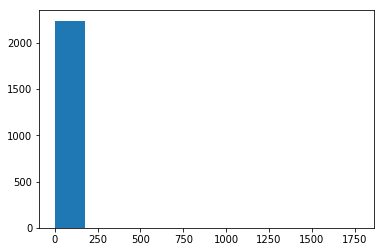

In [864]:
plt.hist(dogs_clean.rating_numerator);

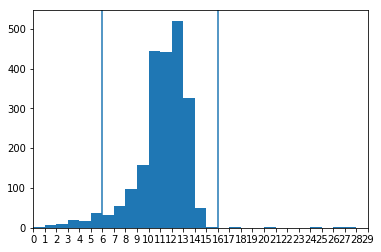

In [869]:
plt.subplot(111)
plt.hist(dogs_clean.rating_numerator, bins=range(0, 30, 1));
plt.xlim(0, 20)
plt.xticks(range(0, 30, 1))
plt.axvline(x= np.percentile(dogs_clean.rating_numerator, 5))
plt.axvline(x= 16)

In [870]:
dogs_clean[dogs_clean.rating_numerator < 5]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
315,835152434251116546,None,None,2017-02-24 15:40:31,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10,None,None,NaT,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/YbEJPkg4Ag
765,777885040357281792,None,None,2016-09-19 15:00:20,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in,None,None,NaT,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1",3,10,Wesley,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/pL7wbMRW7M
883,760252756032651264,None,None,2016-08-01 23:15:56,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet,None,None,NaT,https://twitter.com/dog_rates/status/760252756032651264/photo/1,4,10,Fido,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/4gOv2Q3iKP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,666287406224695296,None,None,2015-11-16 16:11:11,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,None,None,NaT,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/d9NcXFKwLv
2338,666104133288665088,None,None,2015-11-16 04:02:55,Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10,None,None,NaT,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/Asgdc6kuLX
2349,666051853826850816,None,None,2015-11-16 00:35:11,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10,None,None,NaT,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/v5A4vzSDdc


Many of the ratings below 5 aren't for dogs, some are read wrong because the user uses floats like 13.5/10, so it read 5/10, so I will first try to extract those because they're floats and then drop those below 5 ratings because most of them aren't for dogs and I will round the float ratings to integers since actually they're all good dogs and ratings system here isn't ordinal

In [871]:
incorrect_numerators = dogs_clean.text.str.extract('(\d+\.\d+)\s*/\s*(10)').dropna()
incorrect_numerators

,0,1
45,13.5,10
695,9.75,10
763,11.27,10
1689,9.5,10
1712,11.26,10


In [872]:
dogs_clean.iloc[incorrect_numerators.index]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
46,883360690899218434,None,None,2017-07-07 16:22:55,Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck,None,None,NaT,https://twitter.com/dog_rates/status/883360690899218434/photo/1,13,10,Grizzwald,None,floofer,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/rf661IFEYP
788,774314403806253056,None,None,2016-09-09 18:31:54,I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS,None,None,NaT,"https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1",14,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/7oQ1wpfxIH
865,762316489655476224,None,None,2016-08-07 15:56:28,This is Scout. He specializes in mid-air freeze frames. 11/10,None,None,NaT,https://twitter.com/dog_rates/status/762316489655476224/photo/1,11,10,Scout,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/sAHmwRtfSq
1801,676957860086095872,None,None,2015-12-16 02:51:45,10/10 I'd follow this dog into battle no questions asked,None,None,NaT,https://twitter.com/dog_rates/status/676957860086095872/video/1,10,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/ngTNXYQF0L
1824,676496375194980353,None,None,2015-12-14 20:17:59,Say hello to Griffin. He's upset because his costume for Halloween didn't arrive until today. 9/10 cheer up pup,None,None,NaT,https://twitter.com/dog_rates/status/676496375194980353/photo/1,9,10,Griffin,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/eoBCjSFajX


Analayzing the tweets:
the tweet at 1698 is responding to another of his tweets and conveys really no additional info., so I will drop it


In [462]:
dogs_clean[dogs_clean.tweet_id == '681339448655802368']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
1690,681339448655802368,None,None,2015-12-28 05:02:37,This is Asher. He's not wearing a seatbelt or keeping both paws on the wheel. Absolute menace on the roadways. 9/10,None,None,NaT,https://twitter.com/dog_rates/status/681339448655802368/photo/1,9,10,Asher,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/V3SWuHACkh


<hr>

#### fixing puppo, pupper, doggo columns

Before converting puppo, pupper, doggo to a stage column, we should clean the 'None' string objects

In [47]:
cleaning_None_objects(dogs_clean, ['doggo', 'pupper', 'puppo', 'floofer'])

In [48]:
dogs_clean[['doggo', 'puppo', 'pupper']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
doggo     97 non-null object
puppo     30 non-null object
pupper    257 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


Also, it's logical that a dog cannot be both pupper and doggo for example because they're different ages, but nothing is guaranteed from messy data, so I will check for this

In [49]:
## Checking for crossed values before melting

# this function checks if there dogs classified as either (doggo, pupper), 
# (doggo, puppo), (pupper, puppo) or (doggo, pupper, puppo)

dogs_stages = ['doggo', 'puppo', 'pupper']

for i in range(len(dogs_stages)):
    j = i + 1
    for j in range(i + 1, len(dogs_stages)):
        print('(%s, %s)' %(dogs_stages[i], dogs_stages[j]),
             dogs_clean.query('%s == "%s" and %s == "%s"'%(dogs_stages[i], dogs_stages[i], dogs_stages[j], dogs_stages[j])).shape[0]
             )

## Checking for three columns
print('(%s, %s, %s)' %('doggo', 'puppo', 'pupper'),
             dogs_clean.query('doggo == "doggo" and puppo == "puppo" and pupper == "pupper"').shape[0]
     )

(doggo, puppo) 1
(doggo, pupper) 12
(puppo, pupper) 0
(doggo, puppo, pupper) 0


It seems that there are 1 dog classifed as both doggo and puppo and 12 classifed as both doggo and pupper, so I will check the urls of those dogs

In [50]:
dogs_clean.query('doggo == "doggo" and puppo == "puppo"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
191,855851453814013952,None,None,2017-04-22 18:31:02 +0000,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for,None,None,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/cMhq16isel


It seems that this dog is actually puppo, so I will change this doggo entry to None

In [51]:
dogs_clean.loc[191, 'doggo'] = None

In [52]:
## Testing
assert dogs_clean.query('doggo == "doggo" and puppo == "puppo"').shape[0] == 0

In [53]:
pd.set_option('display.max_rows', 30)
dogs_clean.query('doggo == "doggo" and pupper == "pupper"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
460,817777686764523521,None,None,2017-01-07 16:59:28 +0000,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",None,None,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/m7isZrOBX7
531,808106460588765185,None,None,2016-12-12 00:29:28 +0000,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,None,None,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/ANBpEYHaho
565,802265048156610565,733109485275860992,4196983835,2016-11-25 21:37:47 +0000,"Like doggo, like pupper version 2. Both 11/10",None,None,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/9IxWAXFqze
575,801115127852503040,None,None,2016-11-22 17:28:25 +0000,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,None,None,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/55Dqe0SJNj
705,785639753186217984,None,None,2016-10-11 00:34:48 +0000,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,None,None,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/f2wmLZTPHd
733,781308096455073793,None,None,2016-09-29 01:42:20 +0000,"Pupper butt 1, Doggo 0. Both 12/10",None,None,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,Vine - Make a Scene,http://vine.co,https://t.co/WQvcPEpH2u
778,775898661951791106,None,None,2016-09-14 03:27:11 +0000,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10",733109485275860992,4196983835,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/pG2inLaOda
822,770093767776997377,None,None,2016-08-29 03:00:36 +0000,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo,741067306818797568,4196983835,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/o5J479bZUC
889,759793422261743616,None,None,2016-07-31 16:50:42 +0000,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",None,None,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/MYwR4DQKll
956,751583847268179968,None,None,2016-07-09 01:08:47 +0000,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,None,None,NaN,https://twitter.com/dog_rates/status/751583

Checking the urls, one dog is actually only pupper, but others contains a photo of a doggo with his pupper and one isn't actually a dog, so should I convert the columns to one column dog_stage or should I convert each to boolean and clean the incorrect ones.

In [54]:
pd.melt(dogs_clean, id_vars=['tweet_id'], value_vars=['doggo', 'puppo', 'pupper'])['variable']

0       doggo 
1       doggo 
2       doggo 
3       doggo 
4       doggo 
5       doggo 
6       doggo 
7       doggo 
8       doggo 
9       doggo 
10      doggo 
11      doggo 
12      doggo 
13      doggo 
14      doggo 
        ...   
7053    pupper
7054    pupper
7055    pupper
7056    pupper
7057    pupper
7058    pupper
7059    pupper
7060    pupper
7061    pupper
7062    pupper
7063    pupper
7064    pupper
7065    pupper
7066    pupper
7067    pupper
Name: variable, Length: 7068, dtype: object